In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
directory = "../input/combined-handwritten-roman-numerals-dataset/Combined Handwritten Roman Numerals Dataset"
user_data = directory + "/train"
valid_data = directory + "/val"
test_data = directory + "/test"

In [3]:
batch_size = 8

train = tf.keras.preprocessing.image_dataset_from_directory(
        user_data,
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

valid = tf.keras.preprocessing.image_dataset_from_directory(
        valid_data,
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

test = tf.keras.preprocessing.image_dataset_from_directory(
        test_data,
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=False,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

Found 4543 files belonging to 10 classes.


2022-02-16 12:14:13.541138: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 1301 files belonging to 10 classes.
Found 660 files belonging to 10 classes.


In [4]:
stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        min_delta=0,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )

checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "best_model",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    )

In [5]:
start = timer()
base_model = tf.keras.applications.ResNet50(
        input_shape=(32, 32, 3),
        include_top=False,
        weights=None,
    )
base_model = tf.keras.Model(
        base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
    )

inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, x)

model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

loss_0, acc_0 = model.evaluate(valid)
print(f"loss {loss_0}, acc {acc_0}")

history = model.fit(
        train,
        validation_data=valid,
        epochs=100,
        callbacks=[stopping, checkpoint]
)

model.load_weights("best_model")

loss, acc = model.evaluate(valid)
print(f"final loss {loss}, final acc {acc}")

test_loss, test_acc = model.evaluate(test)
print(f"test loss {test_loss}, test acc {test_acc}")
    
end = timer()
print("Time taken = " + str(end - start) + ' s')

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-02-16 12:14:15.799193: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


163/163 [==============================] - 4s 20ms/step - loss: 16.5440 - accuracy: 0.0938
loss 16.544015884399414, acc 0.09377402067184448
Epoch 1/100
568/568 [==============================] - 28s 45ms/step - loss: 1.9533 - accuracy: 0.3328 - val_loss: 1.6484 - val_accuracy: 0.4120
Epoch 2/100
568/568 [==============================] - 24s 43ms/step - loss: 1.3957 - accuracy: 0.5362 - val_loss: 1.3635 - val_accuracy: 0.5304
Epoch 3/100
568/568 [==============================] - 25s 43ms/step - loss: 1.0709 - accuracy: 0.6564 - val_loss: 0.9480 - val_accuracy: 0.7010
Epoch 4/100
568/568 [==============================] - 25s 44ms/step - loss: 0.8413 - accuracy: 0.7315 - val_loss: 0.7712 - val_accuracy: 0.7479
Epoch 5/100
568/568 [==============================] - 25s 43ms/step - loss: 0.7043 - accuracy: 0.7816 - val_loss: 0.6350 - val_accuracy: 0.8063
Epoch 6/100
568/568 [==============================] - 25s 44ms/step - loss: 0.6081 - accuracy: 0.8094 - val_loss: 0.6321 - val_accurac

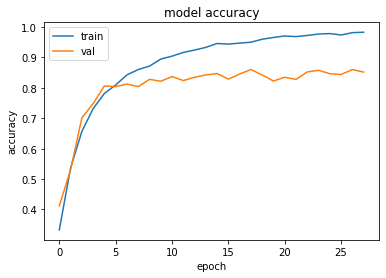

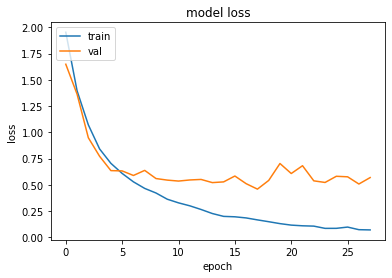

In [6]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()